In [ ]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
import numpy as np
from keras.utils.vis_utils import plot_model

%matplotlib inline

from tensorflow.python import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
'''Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
# Summary of the algorithm
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
# Data download
English to French sentence pairs.
http://www.manythings.org/anki/fra-eng.zip
Lots of neat sentence pairs datasets can be found at:
http://www.manythings.org/anki/
# References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype ='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

            
            
            

In [43]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_sequences=True)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs2, _, _ = decoder_lstm2(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs2)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [44]:
# updatable plot
# a minimal example (sort of)
import keras
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('acc'))
        self.val_accuracies.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.accuracies, label="acc")
        plt.plot(self.x, self.val_accuracies, label="val_acc")
        plt.legend()
        plt.show()
        plt.rcParams["figure.figsize"] = [16,9]
        
plot_losses = PlotLosses()

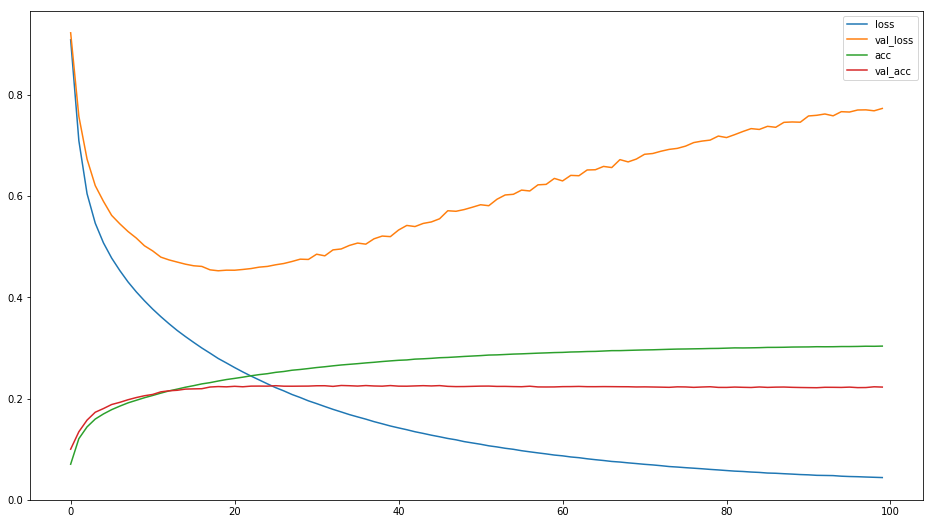

/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_29 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_27/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_27/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [45]:
epochs = 100
# Run training
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['acc'])

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
         callbacks=[plot_losses])
# Save model
model.save('s2s.h5')

In [10]:
model.evaluate([encoder_input_data, decoder_input_data], decoder_target_data, )

10000/10000 [==============================] - 9s 861us/step


0.1899709447324276

In [48]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_outputs, state_h, state_c = decoder_lstm2(
    decoder_outputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


ValueError: Dimensions must be equal, but are 256 and 93 for 'lstm_29_2/MatMul' (op: 'MatMul') with input shapes: [?,256], [93,256].

In [49]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:', target_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Target sentence: 	Va !

Decoded sentence: Va !

-
Input sentence: Hi.
Target sentence: 	Salut !

Decoded sentence: Salut !

-
Input sentence: Run!
Target sentence: 	Cours !

Decoded sentence: Cours !

-
Input sentence: Run!
Target sentence: 	Courez !

Decoded sentence: Cours !

-
Input sentence: Wow!
Target sentence: 	Ça alors !

Decoded sentence: Ça alors !

-
Input sentence: Fire!
Target sentence: 	Au feu !

Decoded sentence: Au feu !

-
Input sentence: Help!
Target sentence: 	À l'aide !

Decoded sentence: À l'aide !

-
Input sentence: Jump.
Target sentence: 	Saute.

Decoded sentence: Saute.

-
Input sentence: Stop!
Target sentence: 	Ça suffit !

Decoded sentence: Stop !

-
Input sentence: Stop!
Target sentence: 	Stop !

Decoded sentence: Stop !

-
Input sentence: Stop!
Target sentence: 	Arrête-toi !

Decoded sentence: Stop !

-
Input sentence: Wait!
Target sentence: 	Attends !

Decoded sentence: Attendez !

-
Input sentence: Wait!
Target sentence: 	Attendez !



-
Input sentence: Call us.
Target sentence: 	Appelez-nous !

Decoded sentence: Appelle-nous !

-
Input sentence: Come in.
Target sentence: 	Entrez !

Decoded sentence: Entrez !

-
Input sentence: Come in.
Target sentence: 	Entre.

Decoded sentence: Entrez !

-
Input sentence: Come in.
Target sentence: 	Entre !

Decoded sentence: Entrez !

-
Input sentence: Come in.
Target sentence: 	Entrez !

Decoded sentence: Entrez !

-
Input sentence: Come on!
Target sentence: 	Allez !

Decoded sentence: Allez !

-
Input sentence: Come on.
Target sentence: 	Allez !

Decoded sentence: Venez !

